In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

plt.style.use('ggplot')

In [2]:
#use previous fitting

#PK decay kinetics (ask Yunda for ranges!)
#t should be in days...
def Ab_conc(t,conc):
    r1=1.5
    r2=0.3
    c=conc*7
    return c*np.exp(-r1*t)+c/4*np.exp(-r2*t)

#to draw from my fit distribution from previous
def draw_IC():
    x=np.linspace(-1,2,1000)
    gmix=2*norm.pdf(x, -0.01, 0.3)+norm.pdf(x, 1.7, 0.2)
    fitIC=gmix/sum(gmix)
    return np.random.choice(x, p=fitIC(x))

#translate to dose response curve
def response80(dose,IC80):
    hill=1.3
    IC50 = IC80*4**(1/hill) 
    res = 1/(1+(dose/IC50)**-hill)
    return res



In [3]:
#set of diff eqs that describes immunologic dynamics simple
Y=np.zeros(5); #intialize ode solution vector
def odemodel(X,t,IC80,IC80_res):          
    
    S=X[0]; I=X[1]; V=X[2]; Ir=X[3]; Vr=X[4] #including resistant states
    
    dose=Ab_conc(t,0) #no Ab for now
    #dose=Ab_conc((t%56)/7,Ab0)

    prop_inhib=response80(dose,IC80)
    prop_inhib_res=response80(dose,IC80_res) #includes Ab resistant IC80

    Bt=Bt0*(1-prop_inhib) #ab dependent infectivity
    Btr=Bt0*(1-prop_inhib_res) #ab dependent infectivity for resistant

    Y[0] = aS - dS*S - Bt*S*V - Btr*S*Vr;
    Y[1] = Bt*S*V*(1-mu) + Btr*S*Vr*mu - dI*I;
    Y[2] = Bt*S*V*mu + Btr*S*Vr*(1-mu) - dIr*I;
    Y[3] = pi*I-gam*V
    Y[4] = pir*Ir-gamr*Vr
    
    return Y   # for odeint

#actually simulate with scipy
def ode_simulate(X0,t):
    IC80=0
    IC80_res=0
    ode_sim = spi.odeint(odemodel,X0,t,(IC80,IC80_res)) 
    return ode_sim    
    

/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/danielreeves/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


R_0 7.246376811594203
ep_c 0.862


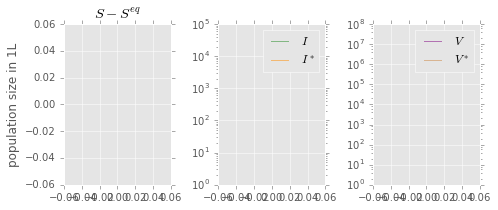

In [5]:
#check R_ calculation

#parameters for simulations
#cellular parameters
vol=1
aS  = 100*vol         # constant growth rate of suseceptible cells
dS  = 0.03            # death rate of suseceptible cells
Bt0 = 1e-4/vol*0.05   # infection rate of T-cells
dI  = 1               # death rate of infected cells
dIr = 1               # death rate of infected cells
pi = 1e4              # burst rate of virus from cells
pir = 1e4             # burst rate of virus from cells
gam = 23              # virus clearance rate
gamr= 23              # virus clearance rate
mu  = 1e-5            # mutation rate

R0=aS*Bt0*pi/gam/dS/dI

print('R_0',R0)
print('ep_c',1-1/R0)

t=np.linspace(0,21,1e3)
X0=np.array([aS/dS,1,0,0,0])

sol = ode_simulate(X0,t)

plt.figure(figsize=(7,3),dpi=600)
plt.subplot(131)
plt.plot(t,sol[:,0]-X0[0],color='gray',alpha=0.5)
#plt.ylim([3e9,4e9])
plt.title('$S-S^{eq}$')
plt.ylabel('population size in 1L')
plt.subplot(132)
plt.semilogy(t,sol[:,1]+1/vol,color='forestgreen',alpha=0.5)
plt.semilogy(t,sol[:,3]+1/vol,color='darkorange',alpha=0.5)
plt.ylim([1,1e5])
plt.legend(['$I$','$I^*$'])
plt.subplot(133)
plt.semilogy(t,sol[:,2]+1/vol,color='purple',alpha=0.5)
plt.semilogy(t,sol[:,4]+1/vol,color='peru',alpha=0.5)
plt.ylim([1,1e8])
plt.legend(['$V$','$V^*$'])
plt.tight_layout()

In [31]:
#updating the rates of events
num_rates=10; num_states=5; r=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

def update_rates(X,t,Ab0,IC80,IC80_res):
        
    dose=Ab_conc(t,Ab0)
    #dose=Ab_conc((t%56)/7,Ab0)

    prop_inhib=response80(dose,IC80)
    prop_inhib_res=response80(dose,IC80_res) #includes Ab resistant IC80

    Bt=Bt0*(1-prop_inhib) #ab dependent infectivity
    Btr=Bt0*(1-prop_inhib_res) #ab dependent infectivity for resistant
    
    S=X[0]; I=X[1]; V=X[2]; Ir=X[3]; Vr=X[4] #including resistant states
    
    p=np.random.poisson(pi); pr=np.random.poisson(pir) #poisson distributed burst sizes, maybe don't need these?

    r[0] = aS;              T[0][:]=[1,0,0,0,0]   #constant production 
    r[1] = dS*S;            T[1][:]=[-1,0,0,0,0]   #density dependent susceptible death
    r[2] = Bt*S*V*(1-mu);   T[2][:]=[-1,1,-1,0,0]  #infection
    r[3] = Bt*S*V*mu;       T[3][:]=[-1,0,-1,1,0]  #infection with mutation
    r[4] = Btr*S*Vr*(1-mu); T[4][:]=[-1,0,0,1,-1] #resistant infection
    r[5] = Btr*S*Vr*mu;     T[5][:]=[-1,1,0,0,-1] #resistant infection with mutation
    r[6] = dI*I;            T[6][:]=[0,-1,p,0,0]  #infected cell burst
    r[7] = dIr*Ir;          T[7][:]=[0,0,0,-1,pr] #resistant infected cell burst
    r[8] = gam*V;           T[8][:]=[0,0,-1,0,0]  #viral clearance
    r[9] = gamr*Vr;         T[9][:]=[0,0,0,0,-1]  #resistant viral clearance
        
    return r,T #updating the rates of events

#function that solves stochastically using tau-leap method
events=[]
def bnabs_tauleap(t,Ab0,inc_time,IC80,IC80r,X0):

    dt=t[1]; x=X0; y=[] #initialize
    for ti in t:
        
        y.append(x) #the list of states

        r,T = update_rates(x,ti,Ab0,IC80,IC80r) #make new rate vector
        
        E = np.random.poisson(r*dt) #calculate events
        
        events.append(E)
        
        dx = np.sum(np.matrix.transpose(T)*E,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti==inc_time:
            x[3]=x[3]+1
 
        x[x<1]=0 #make sure no negative numbers or fractions
        
    return np.array(y)

R_0 7.246376811594203
ep_c 0.862


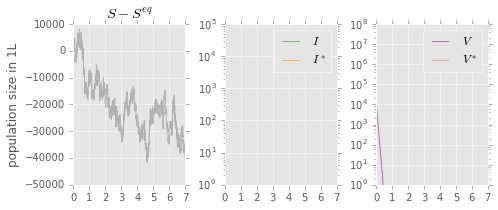

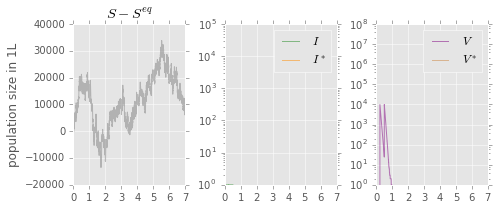

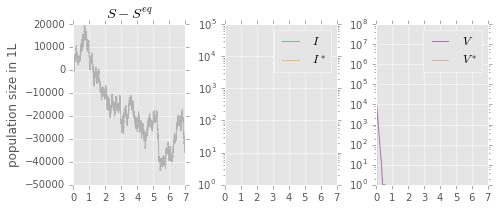

In [49]:
#do a single simulation without antibodies

# parameters for viral dynamics model
#do the population simulations

#parameters for simulations
#cellular parameters
vol=1e6
aS  = 100*vol         # constant growth rate of suseceptible cells
dS  = 0.03            # death rate of suseceptible cells
Bt0 = 1e-4/vol*0.05   # infection rate of T-cells
dI  = 1               # death rate of infected cells
dIr = 1               # death rate of infected cells
pi = 1e4              # burst rate of virus from cells
pir = 1e4             # burst rate of virus from cells
gam = 23              # virus clearance rate
gamr= 23              # virus clearance rate
mu  = 1e-5            # mutation rate

R0=aS*Bt0*pi/gam/dS/dI

print('R_0',R0)
print('ep_c',1-1/R0)

num_runs=3

dt=0.001 #timestep
tF=14 #days

np.linspace(0,tF,tF/dt)

Ab0=10 #10mg/kg
IC80=1
IC80r=10
inc_time=1

X0=np.array([aS/dS,1,0,0,0])

for i in range(num_runs):
    plt.figure(figsize=(7,3),dpi=600)
    sol = bnabs_tauleap(t,Ab0,inc_time,IC80,IC80r,X0)
    plt.subplot(131)
    plt.plot(t,sol[:,0]-X0[0],color='gray',alpha=0.5)
    #plt.ylim([3e9,4e9])
    plt.title('$S-S^{eq}$')
    plt.ylabel('population size in 1L')
    plt.subplot(132)
    plt.semilogy(t,sol[:,1]+1/vol,color='forestgreen',alpha=0.5)
    plt.semilogy(t,sol[:,3]+1/vol,color='darkorange',alpha=0.5)
    plt.ylim([1,1e5])
    plt.legend(['$I$','$I^*$'])
    plt.subplot(133)
    plt.semilogy(t,sol[:,2]+1/vol,color='purple',alpha=0.5)
    plt.semilogy(t,sol[:,4]+1/vol,color='peru',alpha=0.5)
    plt.ylim([1,1e8])
    plt.legend(['$V$','$V^*$'])
    plt.tight_layout()

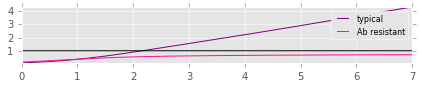

In [50]:
plt.figure(figsize=(7,1),dpi=600)
plt.plot(t,R0*(1-response80(Ab_conc(t,Ab0),IC80)),'purple')
plt.plot(t,R0r*(1-response80(Ab_conc(t,Ab0),IC80r)),'deeppink')
plt.yticks(range(0,5))
plt.plot(t,np.ones(len(t)),color='k')
plt.legend(['typical','Ab resistant'],loc=1,fontsize=8)
